# Disjunctive Programming
Let's compare two different approaches to disjunctive programming: Big-M and convex hull. 

## A simple problem
minimize $ x^\top Q x + q^\top x $

subject to:
$$
\begin{aligned}
x \in R_1 \cup R_2\\
x_{lb} \leq x \leq x_{ub}
\end{aligned}
$$

where $R_i$ is a polyhedron specified by
$$
R_i \equiv \{ x\  |\  A_i x \leq b_i \}
$$

## Binary variables
We'll rewrite the above problem by introducing binary variables $z_i$:

minimize $ x^\top Q x + q^\top x $

over $x$, $z_i$

subject to:
$$
\begin{aligned}
z_1 = 1 \implies x \in R_1\\
z_2 = 1 \implies x \in R_2\\
z_i \in \{0, 1\}\\
\sum_i z_i = 1\\
x_{lb} \leq x \leq x_{ub}
\end{aligned}
$$


## Big-M
The big-M formulation lets us convert the implies operators into linear constraints:

$$
z_i = 1 \implies x \in R_i
$$

becomes

$$
A_i x + M z_i \leq b_i + M
$$

If M is sufficiently big, then when $z_i$ is $0$, the constraint becomes trivial, and when $z_i$ is $1$, the constraint becomes exactly $x \in R_1$. 


# Implementation
## Generating regions
We'll generate the regions as the convex hull of some random points:

In [179]:
using CHull

In [180]:
function hull_points(P::Array{Float64,2})
    hull = chull(P)
    hull_pts = Array(Float64, size(hull.vertices, 1) + 1, size(P, 2))
    line_segments = Dict{Int64,Int64}()
    for i in 1:size(hull.vertices, 1)
        line_segments[hull.vertices[i,1]] = hull.vertices[i,2]
    end
    start = hull.vertices[1,1]
    hull_pts[1,:] = P[start,:]
    for i = 1:size(hull.vertices, 1)
        start = line_segments[start]
        hull_pts[i+1,:] = P[start,:]
    end
    return hull_pts
end
    

hull_points (generic function with 1 method)

In [181]:
dim = 2
num_regions = 2
P = Array{Float64,2}[]
A = Array{Float64,2}[]
b = Array{Float64,2}[]
R = [0 1; -1 0]

for j in 1:num_regions
    P_unordered = rand(4, dim) .+ [j 0]
    push!(P, hull_points(P_unordered))
    push!(A, Array(Float64, size(P[j], 1) - 1, size(P[j])[2]))
    push!(b, Array(Float64, size(A[j], 1), 1))
    for i in 1:size(P[j], 1)-1
        v = P[j][i+1, :] - P[j][i, :]
        
        A[j][i,:] = (R * v.')
        A[j][i,:] = A[j][i,:] ./ norm(A[j][i,:])
        b[j][i,:] = (A[j][i,:] * P[j][i,:].')
    end
end
x_lb = 0
x_ub = num_regions + 2
x_goal = [num_regions / 2 + 1; 1.5]

2-element Array{Float64,1}:
 2.0
 1.5

In [182]:
using JuMP

In [183]:
bigM = Model()

Feasibility problem with:
 * 0 linear constraints
 * 0 variables
Solver set to Default

In [184]:
@defVar(bigM, x[1:dim])

2-element Array{Variable,1}:
 x[1]
 x[2]

In [185]:
@defVar(bigM, z[1:num_regions], Bin)

2-element Array{Variable,1}:
 z[1]
 z[2]

In [186]:
@addConstraint(bigM, sum(z) == 1)

z[1] + z[2] = 1

In [187]:
M = 100
for i in 1:num_regions
    @addConstraint(bigM, A[i] * x .+ M * z[i] .<= b[i] .+ M)
end


In [188]:
@addConstraint(bigM, x_lb .<= x)
@addConstraint(bigM, x .<= x_ub)

2-element Array{ConstraintRef{GenericRangeConstraint{GenericAffExpr{Float64,Variable}}},1}:
 x[1] ≤ 4
 x[2] ≤ 4

In [189]:
@setObjective(bigM, Min, sum((x - x_goal).^2))

:Min

In [190]:
bigM

Minimization problem with:
 * 12 linear constraints
 * 4 variables: 2 binary
Solver set to Default

In [191]:
status = solve(bigM)

Optimize a model with 12 rows, 4 columns and 27 nonzeros
Model has 2 quadratic objective terms
Coefficient statistics:
  Matrix range    [7e-02, 1e+02]
  Objective range [3e+00, 4e+00]
  Bounds range    [1e+00, 1e+00]
  RHS range       [1e+00, 1e+02]
Found heuristic solution: objective -5.43139
Presolve removed 5 rows and 1 columns
Presolve time: 0.00s
Presolved: 7 rows, 3 columns, 21 nonzeros
Presolved model has 2 quadratic objective terms
Variable types: 2 continuous, 1 integer (1 binary)

Root relaxation: objective -6.046221e+00, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -6.04622    0    1   -5.43139   -6.04622  11.3%     -    0s
H    0     0                      -5.9327067   -6.04622  1.91%     -    0s
     0     0   -6.00561    0    1   -5.93271   -6.00561  1.23%     -    0s

Cutting planes:
  MIR: 2

Explored 0 nodes (12 simplex i

:Optimal

In [192]:
using PyPlot

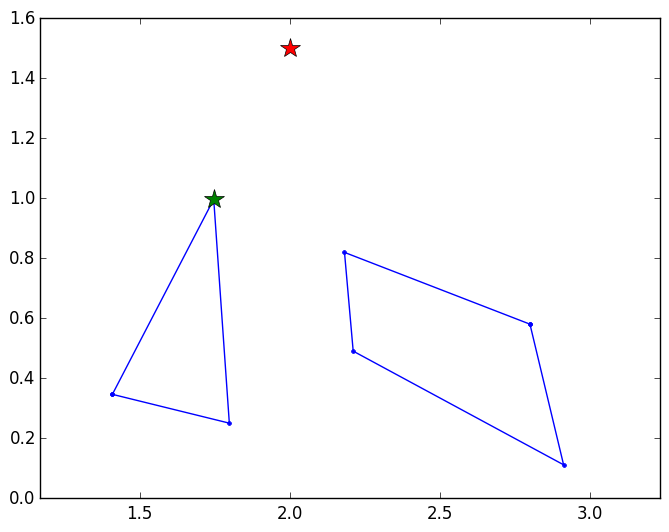

(1.4000000000000001,3.0,0.0,1.6)

In [193]:
figure()
hold(1)
for j in 1:num_regions
    plot(P[j][:,1], P[j][:,2], "b.-")
end
plot([getValue(x[1])], [getValue(x[2])], "g*", markersize=15, markerfacecolor="g")
plot([x_goal[1]], [x_goal[2]], "r*", markersize=15)
axis("equal")

## Convex Hull formulation
minimize $ x^\top Q x + q^\top x $

subject to:
$$
\begin{aligned}
v &= u_1 + u_2\\
A_1 u_1 &\leq y_1 b_1\\
A_2 u_2 &\leq y_2 b_2\\
y_1 x_{lb} &\leq u_1 \leq y_1 x_{ub}\\
y_2 x_{lb} &\leq u_2 \leq y_2 x_{ub}\\
y_i &\in \{0, 1\}
\end{aligned}
$$

where $R_i$ is a polyhedron specified by
$$
R_i \equiv \{ x\  |\  A_i x \leq b_i \}
$$




In [194]:
conv = Model()

Feasibility problem with:
 * 0 linear constraints
 * 0 variables
Solver set to Default

In [195]:
@defVar(conv, v[1:dim])

2-element Array{Variable,1}:
 v[1]
 v[2]

In [196]:
@defVar(conv, u[1:num_regions, 1:dim])

2x2 Array{Variable,2}:
 u[1,1]  u[1,2]
 u[2,1]  u[2,2]

In [197]:
@defVar(conv, y[1:num_regions], Bin)

2-element Array{Variable,1}:
 y[1]
 y[2]

In [198]:
@addConstraint(conv, sum(y) == 1)

y[1] + y[2] = 1

In [199]:
for i in 1:num_regions
    @addConstraint(conv, A[i] * (u[i,:].') .<= y[i] .* b[i])
end

In [200]:
for i in 1:num_regions
    @addConstraint(conv, y[i] * x_lb .<= u[i,:])
    @addConstraint(conv, u[i,:] .<= y[i] * x_ub)
end

In [201]:
@defExpr(sum_u, sum{u[i,:], i=1:num_regions})
@addConstraint(conv, v .== vec(sum_u))

2-element Array{ConstraintRef{GenericRangeConstraint{GenericAffExpr{Float64,Variable}}},1}:
 v[1] - u[1,1] - u[2,1] = 0
 v[2] - u[1,2] - u[2,2] = 0

In [202]:
@setObjective(conv, Min, sum((v - x_goal).^2))

:Min

In [203]:
status = solve(conv)

Optimize a model with 18 rows, 8 columns and 41 nonzeros
Model has 2 quadratic objective terms
Coefficient statistics:
  Matrix range    [7e-02, 4e+00]
  Objective range [3e+00, 4e+00]
  Bounds range    [1e+00, 1e+00]
  RHS range       [1e+00, 1e+00]
Found heuristic solution: objective -5.43139
Presolve removed 9 rows and 2 columns
Presolve time: 0.00s
Presolved: 9 rows, 6 columns, 29 nonzeros
Presolved model has 2 quadratic objective terms
Variable types: 5 continuous, 1 integer (1 binary)

Root relaxation: objective -5.935353e+00, 19 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -5.93535    0    1   -5.43139   -5.93535  9.28%     -    0s
H    0     0                      -5.9327067   -5.93535  0.04%     -    0s

Explored 0 nodes (19 simplex iterations) in 0.00 seconds
Thread count was 4 (of 8 available processors)

Optimal solution found (t

:Optimal

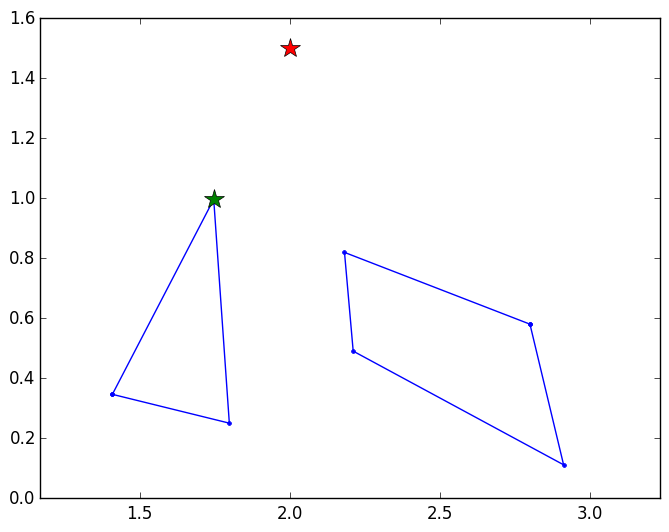

(1.4000000000000001,3.0,0.0,1.6)

In [204]:
figure()
hold(1)
for j in 1:num_regions
    plot(P[j][:,1], P[j][:,2], "b.-")
end
plot([getValue(v[1])], [getValue(v[2])], "g*", markersize=15, markerfacecolor="g")
plot([x_goal[1]], [x_goal[2]], "r*", markersize=15)
axis("equal")